## Parsing Multiple Files

In [2]:
import os
import pandas as pd
import datetime
    
def process_data_in_folder(folder_path, output_file_path):
    
    # Define file paths within the specified folder
    position_file_path = os.path.join(folder_path, "BESTPOS.ASCII")
    inspvax_file_path = os.path.join(folder_path, "INSPVAX.ASCII")
    coreimu_file_path = os.path.join(folder_path, "CORRIMUDATA.ASCII")
    bestvel_file_path = os.path.join(folder_path, "BESTVEL.ASCII")
                        
    # Parse data from each file
    gnss_df = parse_position_data(position_file_path)
    ins_df = parse_inspvax_data(inspvax_file_path)
    acc_df = parse_coreimu_data(coreimu_file_path)
    vel_df = parse_bestvel_data(bestvel_file_path)
    
    # Merge DataFrames based on 'Modtime'
    merged_df = pd.merge(gnss_df, ins_df, on='Modtime', how='inner')
    merged_df = pd.merge(merged_df, acc_df, on='Modtime', how='inner')
    merged_df = pd.merge(merged_df, vel_df, on='Modtime', how='inner')

    merged_df['Delta_Latitude'] = merged_df['Latitude'].diff()
    merged_df['Delta_Longitude'] = merged_df['Longitude'].diff()
    merged_df['Delta_Altitude'] = merged_df['Altitude'].diff()
    merged_df = merged_df.dropna().reset_index(drop=True)  # Drop the first row with NaN differences and reset index
    # Append merged data to the output CSV file
    save_to_csv(merged_df, output_file_path)
    
def parse_position_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#BESTPOSA'):
                parts = line.split(';')
                time_data, pos_data = parts[0].split(','), parts[1].split(',')

                week = int(time_data[5])  # Assuming GPS week is at index 5
                tow = float(time_data[6])  # Assuming time of week is at index 6

                gps_datetime = gps_week_to_datetime(week, tow)

                lat = float(pos_data[2])
                lon = float(pos_data[3])
                alt = float(pos_data[4])

                data.append((lat, lon, alt, gps_datetime))

    df = pd.DataFrame(data, columns=['Latitude', 'Longitude', 'Altitude', 'Modtime'])
    print("pos",len(df))
    return df

def parse_inspvax_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#INSPVAX'):
                parts = line.split(';')
                time_data, ins_data = parts[0].split(','), parts[1].split(',')

                week = int(time_data[5])  # Assuming GPS week is at index 5
                tow = float(time_data[6])  # Assuming time of week is at index 6

                gps_datetime = gps_week_to_datetime(week, tow)
                roll = float(ins_data[9])
                pitch = float(ins_data[10])
                azimuth = float(ins_data[11])
                data.append((roll, pitch, azimuth, gps_datetime))

    df = pd.DataFrame(data, columns=['Roll', 'Pitch', 'Azimuth', 'Modtime'])
    return df

def parse_coreimu_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#CORRIMUDATA'):
                time_data, fields = line.split(';')
                time_data = time_data.split(',')

                week = int(time_data[5])  # Assuming GPS week is at index 5
                tow = float(time_data[6])  # Assuming time of week is at index 6

                gps_datetime = gps_week_to_datetime(week, tow)

                fields = fields.split(',')
                acc_x = float(fields[5])
                acc_y = float(fields[6])
                acc_z = float(fields[7].split('*')[0])

                data.append((acc_x, acc_y, acc_z, gps_datetime))
    
    df = pd.DataFrame(data, columns=['Acc_x', 'Acc_y', 'Acc_z', 'Modtime'])
    return df

def parse_bestvel_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#BESTVELA'):
                time_data, fields = line.split(';')
                time_data = time_data.split(',')

                week = int(time_data[5])  # Assuming GPS week is at index 5
                tow = float(time_data[6])  # Assuming time of week is at index 6

                gps_datetime = gps_week_to_datetime(week, tow)

                fields = fields.split(',')
                hor_speed = float(fields[4])
                trk_ground = float(fields[5])
                data.append((hor_speed, trk_ground, gps_datetime))
    
    df = pd.DataFrame(data, columns=['Hor_speed', 'Trk_ground', 'Modtime'])
    return df

def gps_week_to_datetime(gps_week, gps_seconds):
    gps_epoch = datetime.datetime(1980, 1, 6, 0, 0, 0)
    total_seconds = gps_week * 7 * 24 * 3600 + gps_seconds
    gps_datetime = gps_epoch + datetime.timedelta(seconds=total_seconds)
    return gps_datetime

def save_to_csv(df, output_file_path):
    # Append DataFrame to CSV file
    df.to_csv(output_file_path, mode='a', header=not os.path.exists(output_file_path), index=False)
 
# Specify the main folder containing subfolders with data
main_folder = "/Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)altitude/training_data"

# Define the output CSV file path
output_file_path = "/Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)altitude/cleaned-data/completedata12.csv"

# Traverse subfolders within the main folder
for root, dirs, files in os.walk(main_folder):
    
    for dir in dirs:
        folder_path = os.path.join(root, dir)
        # Process data in each subfolder and append to the output CSV file
        process_data_in_folder(folder_path, output_file_path)

print(f"All folder data merged and saved to: {output_file_path}")
final_df=pd.read_csv(output_file_path)
print(len(final_df))

pos 72019
pos 993
pos 3603
pos 7908
pos 3041
pos 2502
pos 3906
pos 11395
pos 1537
pos 1643
pos 10907
All folder data merged and saved to: /Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)altitude/cleaned-data/completedata12.csv
119123


In [4]:
# Define the output CSV file path
import pandas as pd
# Define the output CSV file path
output_file_path = "/Users/ravitejakunchanapalli/Desktop/working_project/GNSS-ML-V2(multiple-data)altitude/cleaned-data/completedata12.csv"
final_df=pd.read_csv(output_file_path)
print(len(final_df))

119123


## Random Forest

Latitude Prediction R^2 Score: 0.995227849274604
Longitude Prediction R^2 Score: 0.991168156118565
Altitude Prediction R^2 Score: 0.586249802184248
Mean Squared Error (MSE) for Delta_Latitude: 0.00000000000003968
Mean Squared Error (MSE) for Delta_Longitude: 0.00000000000009402
Mean Squared Error (MSE) for Delta_Altitude: 0.00000000000009402


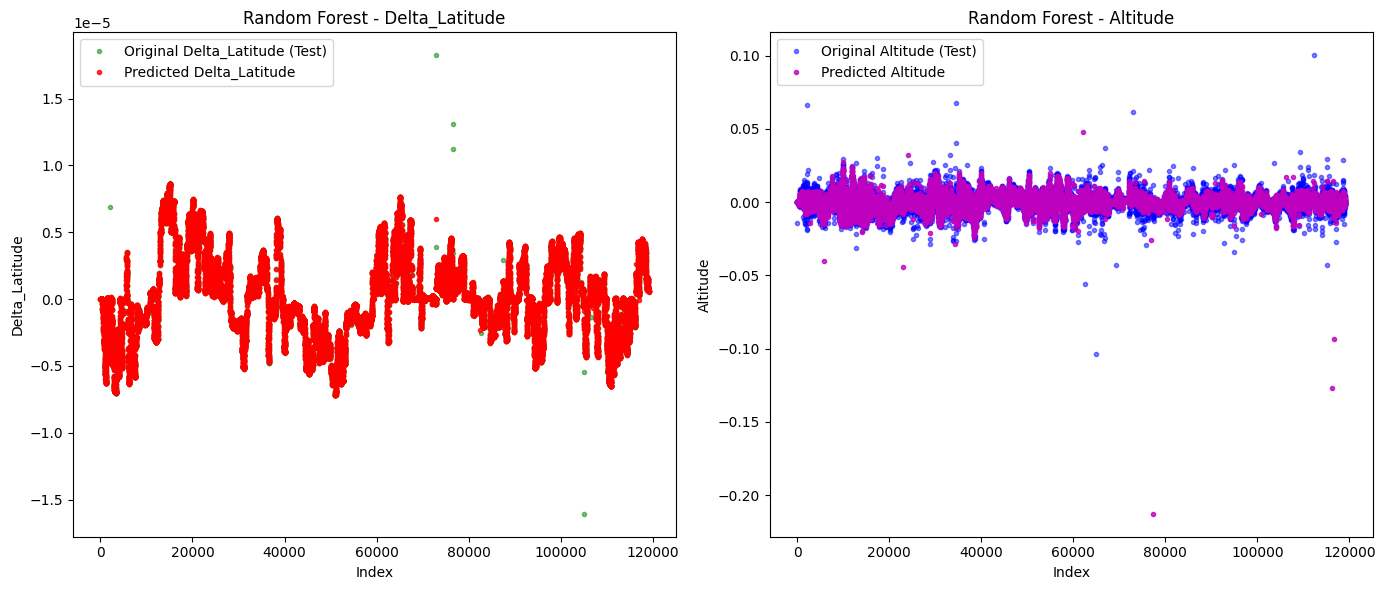

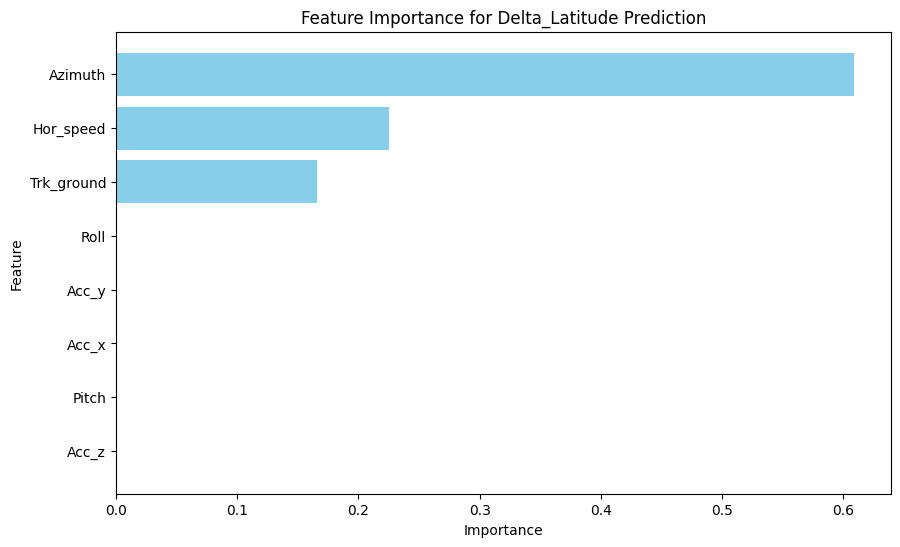

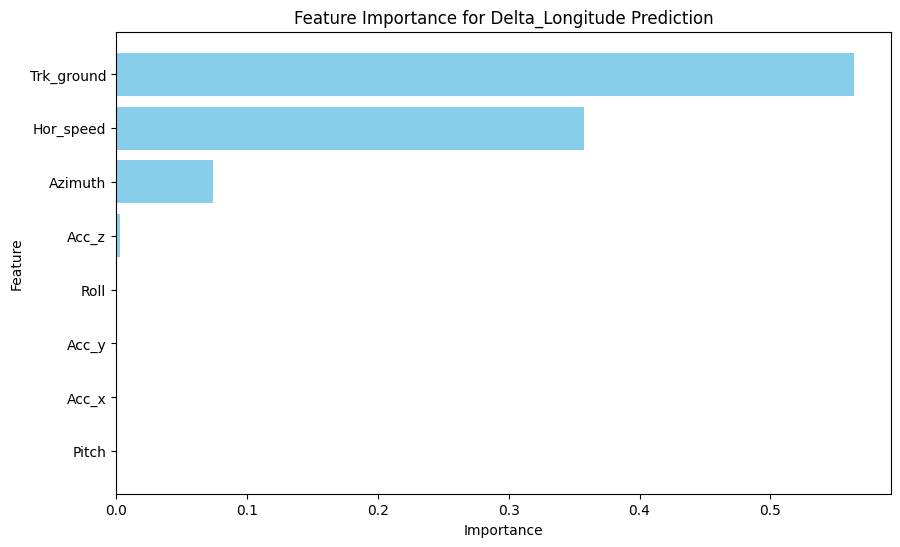

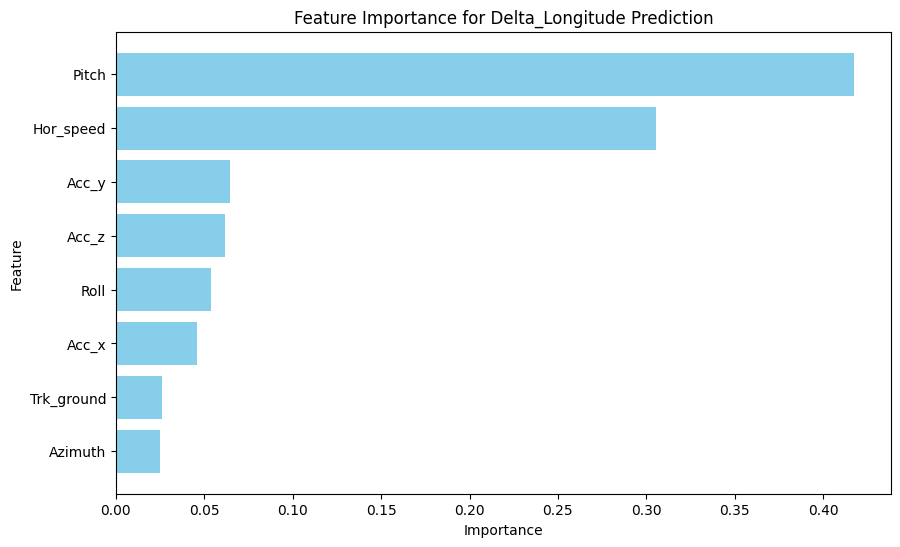

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import joblib

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'
target_alt = 'Delta_Altitude'

# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]
y_alt = final_df[target_alt]
# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test, y_alt_train, y_alt_test = train_test_split(X, y_lat, y_lon, y_alt, test_size=0.2, random_state=42)

# Initialize Random Forest models
model_lat = RandomForestRegressor(n_estimators=100, random_state=42)
model_lon = RandomForestRegressor(n_estimators=100, random_state=42)
model_alt = RandomForestRegressor(n_estimators=100, random_state=42)

# Train Random Forest models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)
model_alt.fit(X_train, y_alt_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'rf_regressor_lat_model.pkl')
joblib.dump(model_lon, 'rf_regressor_lon_model.pkl')
joblib.dump(model_alt, 'rf_regressor_alt_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)
y_alt_pred = model_alt.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)
alt_r2 = r2_score(y_alt_test, y_alt_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")
print(f"Altitude Prediction R^2 Score: {alt_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")

lon_mse=mean_squared_error(y_lon_test,y_lon_pred)
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")

alt_mse=mean_squared_error(y_alt_test,y_alt_pred)
print(f"Mean Squared Error (MSE) for Delta_Altitude: {lon_mse:.17f}")

import matplotlib.pyplot as plt

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Delta_Latitude on the first subplot
axs[0].plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)
axs[0].plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Delta_Latitude')
axs[0].set_title('Random Forest - Delta_Latitude')
axs[0].legend()

# Plotting altitude data on the second subplot
axs[1].plot(X_test.index, y_alt_test, 'b.', label='Original Altitude (Test)', linewidth=2, alpha=0.5)
axs[1].plot(X_test.index, y_alt_pred, 'm.', label='Predicted Altitude', linewidth=1, alpha=0.8)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Altitude')
axs[1].set_title('Random Forest - Altitude')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


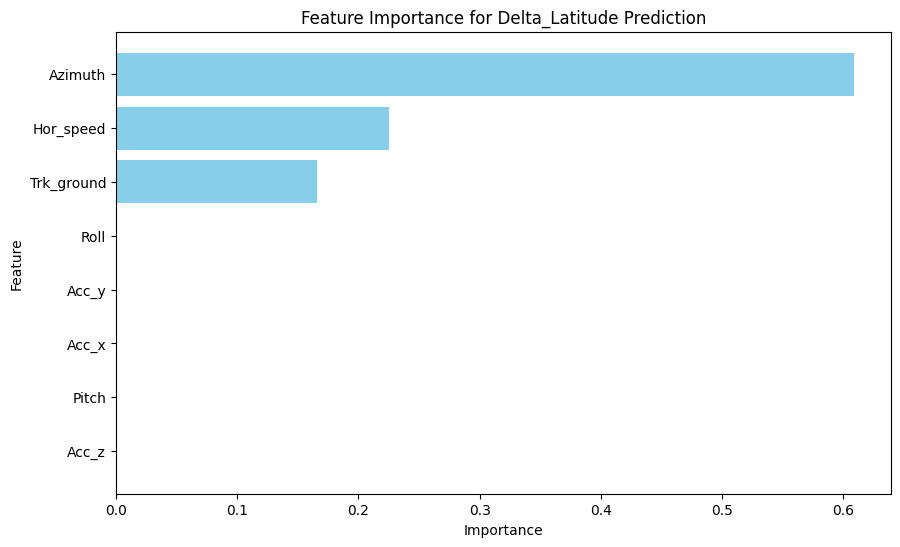

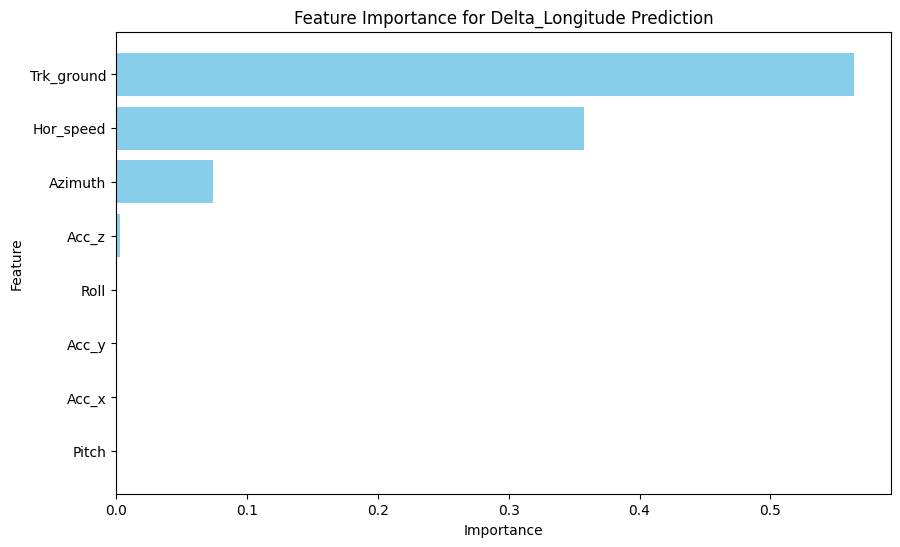

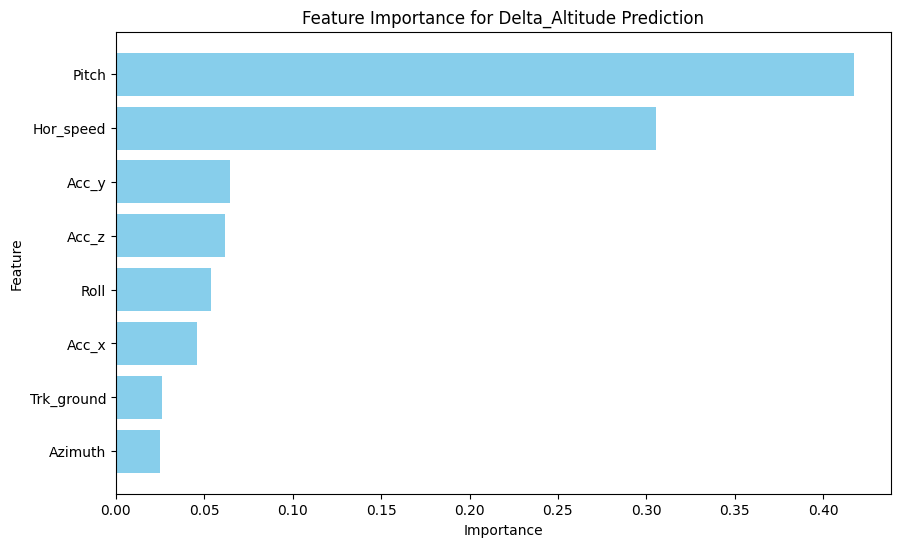

In [7]:
# Feature importance for Delta_Latitude model
lat_importances = model_lat.feature_importances_
lon_importances = model_lon.feature_importances_
alt_importances = model_alt.feature_importances_

# Create DataFrame for feature importances
feature_importance_df_lat = pd.DataFrame({
    'Feature': features,
    'Importance': lat_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df_lon = pd.DataFrame({
    'Feature': features,
    'Importance': lon_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df_alt = pd.DataFrame({
    'Feature': features,
    'Importance': alt_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances for Delta_Latitude
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_lat['Feature'], feature_importance_df_lat['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Delta_Latitude Prediction')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Plot feature importances for Delta_Longitude
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_lon['Feature'], feature_importance_df_lon['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Delta_Longitude Prediction')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Plot feature importances for Delta_Longitude
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_alt['Feature'], feature_importance_df_alt['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Delta_Altitude Prediction')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

## light gbm

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'


# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize LightGBM models
model_lat = LGBMRegressor(n_estimators=100, random_state=42)
model_lon = LGBMRegressor(n_estimators=100, random_state=42)

# Train LightGBM models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'lightgbm_lat_model.pkl')
joblib.dump(model_lon, 'lightgbm_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude and Delta_Longitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
lon_mse = mean_squared_error(y_lon_test, y_lon_pred)

print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")

# Save the trained models to pickle files
joblib.dump(model_lat, 'lgbm_regressor_lat_model.pkl')
joblib.dump(model_lon, 'lgbm_regressor_lon_model.pkl')

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('Light gbm')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()

OSError: dlopen(/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <C3EB28DD-60B6-3334-AFA2-72BBBF9DBAEF> /opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache), '/opt/homebrew/Cellar/libomp/18.1.4/lib/libomp.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/Cellar/libomp/18.1.4/lib/libomp.dylib' (no such file), '/opt/homebrew/Cellar/libomp/18.1.4/lib/libomp.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

## Gradient Boosting

Latitude Prediction R^2 Score: 0.994499653252412
Longitude Prediction R^2 Score: 0.995848359598753
Mean Squared Error (MSE) for Delta_Latitude: 0.00000000000005751
Mean Squared Error (MSE) for Delta_Longitude: 0.00000000000006025


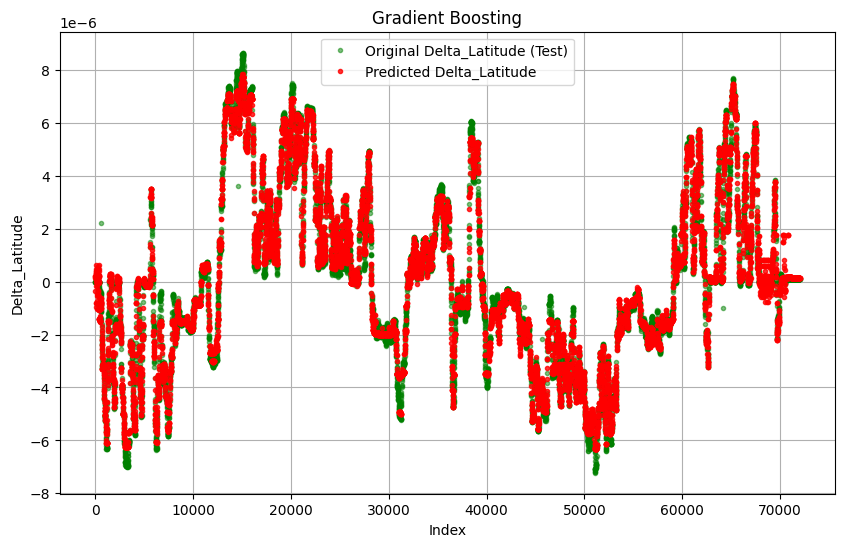

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'


# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize Gradient Boosting models
model_lat = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_lon = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train Gradient Boosting models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'gradient-boost_lat_model.pkl')
joblib.dump(model_lon, 'gradient-boost_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude and Delta_Longitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
lon_mse = mean_squared_error(y_lon_test, y_lon_pred)

print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('Gradient Boosting')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()


## Catboost

Latitude Prediction R^2 Score: 0.998913262219799
Longitude Prediction R^2 Score: 0.999166019324197
Mean Squared Error (MSE) for Delta_Latitude: 0.00000000000001136
Mean Squared Error (MSE) for Delta_Longitude: 0.00000000000001210


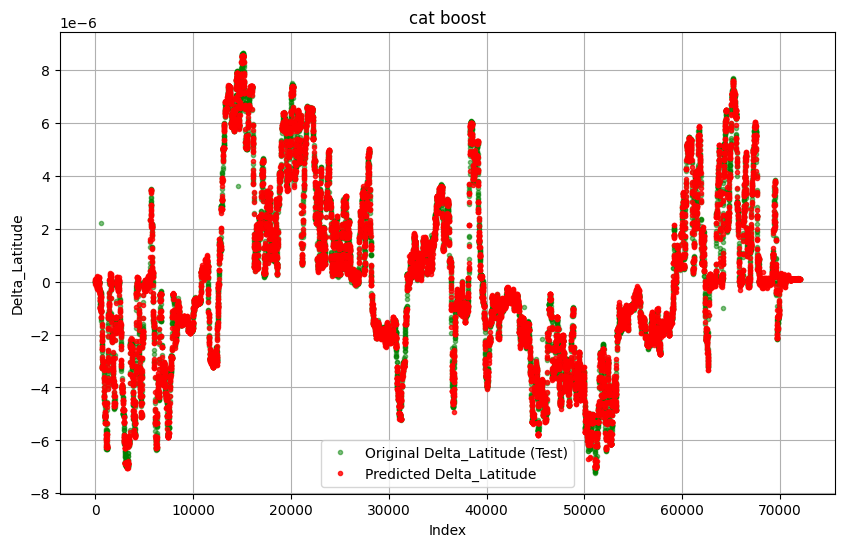

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
from catboost import CatBoostRegressor

# Define features and target variables
features = ['Roll', 'Pitch', 'Azimuth','Acc_x', 'Acc_y', 'Acc_z','Hor_speed','Trk_ground'] 
target_lat = 'Delta_Latitude'
target_lon = 'Delta_Longitude'

# Prepare data
X = final_df[features]
y_lat = final_df[target_lat]
y_lon = final_df[target_lon]

# Split data into train and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize CatBoost models
model_lat = CatBoostRegressor(iterations=100, random_seed=42, verbose=0)
model_lon = CatBoostRegressor(iterations=100, random_seed=42, verbose=0)

# Train CatBoost models
model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Save trained models to pickle files
joblib.dump(model_lat, 'catboost_lat_model.pkl')
joblib.dump(model_lon, 'catboost_lon_model.pkl')

# Make predictions
y_lat_pred = model_lat.predict(X_test)
y_lon_pred = model_lon.predict(X_test)

# Evaluate models
lat_r2 = r2_score(y_lat_test, y_lat_pred)
lon_r2 = r2_score(y_lon_test, y_lon_pred)

print(f"Latitude Prediction R^2 Score: {lat_r2:.15f}")
print(f"Longitude Prediction R^2 Score: {lon_r2:.15f}")

# Calculate Mean Squared Error (MSE) for Delta_Latitude and Delta_Longitude
lat_mse = mean_squared_error(y_lat_test, y_lat_pred)
lon_mse = mean_squared_error(y_lon_test, y_lon_pred)

print(f"Mean Squared Error (MSE) for Delta_Latitude: {lat_mse:.17f}")
print(f"Mean Squared Error (MSE) for Delta_Longitude: {lon_mse:.17f}")

# Plotting predicted Delta_Latitude vs. original Delta_Latitude for testing data
plt.figure(figsize=(10, 6))

# Plot original Delta_Latitude from testing data
plt.plot(X_test.index, y_lat_test, 'g.', label='Original Delta_Latitude (Test)', linewidth=2, alpha=0.5)

# Plot predicted Delta_Latitude
plt.plot(X_test.index, y_lat_pred, 'r.', label='Predicted Delta_Latitude', linewidth=1, alpha=0.8)

# Set x-axis and y-axis labels
plt.xlabel('Index')
plt.ylabel('Delta_Latitude')

# Set plot title
plt.title('cat boost')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()
